# Study of the impact of the reward model on the efficacy of learned policies 

## 1. Description of the goal and content of the notebook

### Goal (informal)

We want a scalar metric that captures how *useful* a reward model (R) is for producing, early in training, a Q-table that induces a policy which:
   - (1) reaches the FrozenLake goal
   - (2) does so by a short path.
   
Intuitively: a good reward model should "guide" the agent quickly toward a minimal-length path to the goal.

---

### Experimentation sand-box

- We use the classic $(8\times 8)$ FrozenLake environment with `is_slippery=False`.
- We define 3 reward models:

   - `basic_rm`: Basic reward model giving a reward of 1 for reaching the goal and 0 otherwise.
   
   - `hacky_rm`: Hacky reward model giving a reward of 10 for reaching the goal, -10 for falling in a hole, and -1 otherwise to push encourage minimal path length.
   
   - `hacky_manhattan_rm`: Hacky reward model giving a reward of 10 for reaching the goal, -10 for falling in a hole, and a negative reward based on the Manhattan distance to the goal otherwise to encourage further minimal path length.

---

### The proposed metric

- We propose a simple metric called "reward model efficiency score" or $RMES$.

- Given a reward model $R(s)$ which assigns a reward to each state $s$ reached when interacting with the environment, $RMES$ is computed as follows:

   1. We define beforehand a fixed pool of increasing decay rates for the $\epsilon$ parameter of the $\epsilon$-greedy policy in Q-learning.

   2. For each decay rate, we train our agent via Q-learning.

   3. After every single episode during training, we evaluate the "quality" of the current state of the Q-table by:
      - [a] Computing the length of the "path to the goal" suggested by following greedily the entries of the Q-table.
      - [b] If the greedy path does lead to the goal, we assign a "local score" to the current episode which is defined by: $$PerEpisodeScore = \frac{MinimumPathLength}{DiscoveredPathLength}$$
      with $MinimumPathLength$ being the manhattan distance from start state to goal state (in default 8 by 8 FrozenLake this is just 14 steps). In case the greedy path doesn't lead to the goal, we set the score to 0 which is equivalent to saying that $DiscoveredPathLength = \infty$
   
   4. At the end of the training, we compute an average of these scores, which we call "decay rate efficiency score" and which is defined by:$$DecayRateEfficiencyScore = \frac{Sum(PerEpisodeScores)}{NumberOfEpisodes}$$This score is by design normalized between 0 and 1, and represents effectively the area under the curve of the per-episode scores.

   5. After obtaining the different decay rate efficiency scores, we compute the area under the curve obtaind by plotting these scores against the decay rates, effectively computing a final score that represents the "quality" of the reward model, defined by:$$RewardModelEfficiencyScore = AUC(DecayRateEfficiencyScores / DecayRates)$$

- This score effectively represents how "fast" the q-learning algorithm reaches an optimal solution: as we increase the $\epsilon$ decay rate, the agent has less time to explore its environment, and a less efficient reward model would lead to sub-optimal solutions in this case, while a more informative reward model should still be able to guide the agent towards an optimal solution even under limited exploration time, thus leading to "quicker learning of better solutions".

- This metric we propose aims to represent exactly that, and as we can see in the plots generated in this notebook, the $RewardModelEfficiencyScore$ is highest for `hacky_manhattan_rm`, then `hacky_rm`, and finally the least informative `basic_rm`, as we may intuitively suppose.

# 2. Implementation

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import tqdm

### Environment and static parameters initialization

In [ ]:
# Environment initialization
env = gym.make(
    'FrozenLake-v1',
    map_name="8x8",
    is_slippery=False,
    render_mode= None
)

# Environment state dimension (8x8 grid)
ENV_DIM = 8

# Exploration and exploitation learning rate
EXPLORATION_LEARNING_RATE = 0.9
EXPLOITATION_LEARNING_RATE = 0.0001

# Discount factor for future rewards
DISCOUNT_FACTOR = 0.9

# Initial epsilon value for epsilon-greedy policy
INIT_EPSILON = 1.0

# Epsilon decay rates to be generate different exploration-exploitation schedules.
# The decay is algebraic: epsilon_t+1 = epsilon_t - INIT_EPSILON - decay_rate
EPSILON_DECAY_RATES = np.array([0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05])

# To ensure that the exploitation phase is reached for all decay rates, even the slowest one:
# Given that minimum epsilon is 0, and we decay epsilon algebraically, we have nb_exploration_episodes = INIT_EPSILON / decay_rate
# Thus, for decay_rate = 0.0001, we have nb_exploration_episodes = 1.0 / 0.0001 = 10,000
# We set the total number of episodes to a value higher than that to ensure we reach the exploitation phase for all decay rates.
# Here we set it to 15,000.
NB_EPISODES = 15000

### Defining a function that computes the proposed metric for a given reward model "rm"

In [ ]:
def generate_reward_model_efficiency_score(rm):
        print(f'Training "{rm.__name__}" ------------------------------------------\n')

        # List to store the epsilon decay rate efficiency scores for this reward model
        epsilon_decay_rate_efficiency_scores = list()
        
        # For each epsilon decay rate, train an agent and store the obtained epsilon decay rate efficiency score
        for epsilon_decay_rate in EPSILON_DECAY_RATES:
            
            # Initialize Q-table
            q = np.zeros((env.observation_space.n, env.action_space.n)) 

            # Initialize learning rate with exploration learning rate
            learning_rate = EXPLORATION_LEARNING_RATE

            # Initialize epsilon with initial epsilon
            epsilon = INIT_EPSILON
            
            # Set random seed for reproducibility
            np.random.seed(97)

            # List to store the reward-model-independent per-episode scores (to be filled during training)
            per_episode_scores = np.zeros(NB_EPISODES)

            # Training loop
            for i in tqdm.tqdm(range(NB_EPISODES), desc=f"Training for Epsilon Decay Rate = {epsilon_decay_rate:.4f}", unit=" episodes"):
                
                # Reset the environment at the start of each episode
                state = env.reset()[0]
                terminated = False
                truncated = False

                # Episode loop with epsilon-greedy Q-learning
                while(not terminated and not truncated):
                    if np.random.random() < epsilon:
                        action = np.random.randint(0,4) # env.action_space.sample() # actions: 0=left,1=down,2=right,3=up
                    else:
                        action = np.argmax(q[state,:])
                    new_state, _, terminated, truncated, _ = env.step(action)
                    reward = rm(new_state)
                    q[state,action] = q[state,action] + learning_rate * (reward + DISCOUNT_FACTOR * np.max(q[new_state,:]) - q[state,action])
                    state = new_state
                
                # Decay epsilon
                epsilon = max(epsilon - epsilon_decay_rate, 0)
                
                # Decay learning rate
                if(epsilon==0):
                    learning_rate = EXPLOITATION_LEARNING_RATE
                
                # Compute the score for this episode using the greedy policy defined by the current state of the Q-table 
                # The score is either 0 if the goal is not reached
                # or 1 / path_length if the goal is reached (to favor shorter paths)
                path_length = 0
                state = env.reset()[0] # reset environment to start state
                terminated = False
                truncated = False
                while(not terminated and not truncated):
                    path_length += 1
                    action = np.argmax(q[state,:])
                    new_state, _ , terminated, truncated, _ = env.step(action)
                    state = new_state
                if state == (env.observation_space.n - 1):
                    per_episode_scores[i] = 1 / path_length

            env.close()

            # Compute the epsilon decay rate efficiency score which is the normalized area under the curve of the per episode scores

            ## sum the scores per episode to obtain a non normalized area under the curve
            epsilon_decay_rate_efficiency_score = np.sum(per_episode_scores)
            
            ## prepare the normalization coefficient which is just the max area under the curve
            normalization_coeff = NB_EPISODES * (1 / ((ENV_DIM - 1) * 2)) # max score per episode is 1 / min path length which is 2*ENV_DIM
            
            ## normalize the area under the curve to obtain the epsilon_decay_rate_efficiency_score between 0 and 1
            epsilon_decay_rate_efficiency_score /= normalization_coeff
            print(f"    |---> Epsilon Decay Rate Efficiency Score = {epsilon_decay_rate_efficiency_score}\n")

            # Append the epsilon_decay_rate_efficiency_score to the list
            epsilon_decay_rate_efficiency_scores.append(epsilon_decay_rate_efficiency_score)

        # Compute the reward model efficiency score which is the area under the curve for this reward model
        rm_auc = np.trapezoid(
            np.array(epsilon_decay_rate_efficiency_scores),
            EPSILON_DECAY_RATES
        )

        # Plotting the epsilon decay rate efficiency scores for this reward model with the RM AUC in the legend
        plt.plot(EPSILON_DECAY_RATES, epsilon_decay_rate_efficiency_scores)
        plt.fill_between(EPSILON_DECAY_RATES, epsilon_decay_rate_efficiency_scores, alpha=0.3, label=f"AUC={rm_auc:.4f}")
        plt.xlabel("Epsilon Decay Rates")
        plt.ylabel("Epsilon Decay Rate Efficiency Scores")
        plt.title(f'"{rm.__name__}" Reward Model Efficiency Score')
        plt.legend()
        plt.grid()
        plt.show()

### Evaluating the reward model efficiency score of "basic_rm"

Training "basic_rm" ------------------------------------------



Training for Epsilon Decay Rate = 0.0001: 100%|██████████| 15000/15000 [00:05<00:00, 2961.09 episodes/s]


    |---> Epsilon Decay Rate Efficiency Score = 0.9115999999999997



Training for Epsilon Decay Rate = 0.0005: 100%|██████████| 15000/15000 [00:24<00:00, 618.88 episodes/s]


    |---> Epsilon Decay Rate Efficiency Score = 0.0



Training for Epsilon Decay Rate = 0.0010: 100%|██████████| 15000/15000 [00:24<00:00, 604.32 episodes/s]


    |---> Epsilon Decay Rate Efficiency Score = 0.0



Training for Epsilon Decay Rate = 0.0050: 100%|██████████| 15000/15000 [00:24<00:00, 611.63 episodes/s]


    |---> Epsilon Decay Rate Efficiency Score = 0.0



Training for Epsilon Decay Rate = 0.0100: 100%|██████████| 15000/15000 [00:23<00:00, 628.68 episodes/s]


    |---> Epsilon Decay Rate Efficiency Score = 0.0



Training for Epsilon Decay Rate = 0.0500: 100%|██████████| 15000/15000 [00:23<00:00, 630.36 episodes/s]


    |---> Epsilon Decay Rate Efficiency Score = 0.0



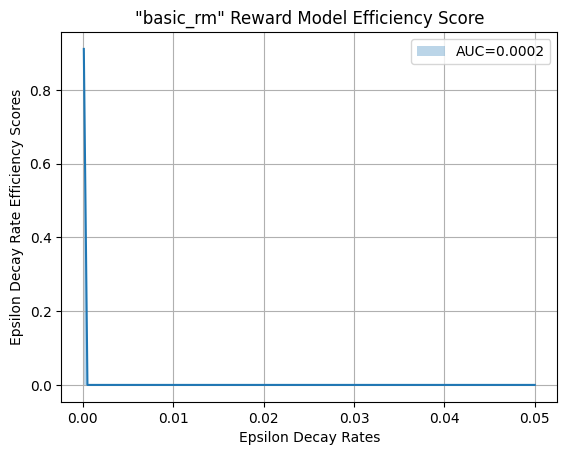

In [38]:
def basic_rm(state):
    """Basic reward model giving a reward of 1 for reaching the goal and 0 otherwise."""
    state = str(env.unwrapped.desc[state//ENV_DIM][state%ENV_DIM])[2]
    if state == "G":
        return 1
    else:
        return 0

generate_reward_model_efficiency_score(basic_rm)

### Evaluating the reward model efficiency score of "hacky_rm"

Training "hacky_rm" ------------------------------------------



Training for Epsilon Decay Rate = 0.0001: 100%|██████████| 15000/15000 [00:04<00:00, 3442.85 episodes/s]


    |---> Epsilon Decay Rate Efficiency Score = 0.9433999999999997



Training for Epsilon Decay Rate = 0.0005: 100%|██████████| 15000/15000 [00:03<00:00, 3934.51 episodes/s]


    |---> Epsilon Decay Rate Efficiency Score = 0.9691999999999998



Training for Epsilon Decay Rate = 0.0010: 100%|██████████| 15000/15000 [00:03<00:00, 4027.08 episodes/s]


    |---> Epsilon Decay Rate Efficiency Score = 0.9725999999999998



Training for Epsilon Decay Rate = 0.0050: 100%|██████████| 15000/15000 [00:03<00:00, 4047.07 episodes/s]


    |---> Epsilon Decay Rate Efficiency Score = 0.9892666666666664



Training for Epsilon Decay Rate = 0.0100: 100%|██████████| 15000/15000 [00:09<00:00, 1519.89 episodes/s]


    |---> Epsilon Decay Rate Efficiency Score = 0.24786666666666662



Training for Epsilon Decay Rate = 0.0500: 100%|██████████| 15000/15000 [00:15<00:00, 985.82 episodes/s] 

    |---> Epsilon Decay Rate Efficiency Score = 0.005228703703703704



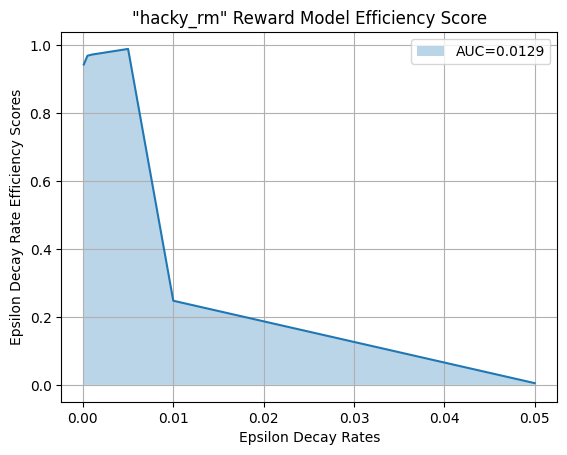

In [ ]:
def hacky_rm(state):
    """Hacky reward model giving a reward of 10 for reaching the goal, -10 for falling in a hole, and -1 otherwise to push encourage minimal path length."""
    state = str(env.unwrapped.desc[state//ENV_DIM][state%ENV_DIM])[2]
    if state == "G":
        return 10
    if state == "H":
        return -10
    else:
        return -1

generate_reward_model_efficiency_score(hacky_rm)

### Evaluating the reward model efficiency score of "hacky_manhattan_rm"

Training "hacky_manhattan_rm" ------------------------------------------



Training for Epsilon Decay Rate = 0.0001: 100%|██████████| 15000/15000 [00:04<00:00, 3385.45 episodes/s]


    |---> Epsilon Decay Rate Efficiency Score = 0.9450666666666664



Training for Epsilon Decay Rate = 0.0005: 100%|██████████| 15000/15000 [00:04<00:00, 3748.19 episodes/s]


    |---> Epsilon Decay Rate Efficiency Score = 0.968333333333333



Training for Epsilon Decay Rate = 0.0010: 100%|██████████| 15000/15000 [00:03<00:00, 3864.86 episodes/s]


    |---> Epsilon Decay Rate Efficiency Score = 0.975133333333333



Training for Epsilon Decay Rate = 0.0050: 100%|██████████| 15000/15000 [00:03<00:00, 3824.06 episodes/s]


    |---> Epsilon Decay Rate Efficiency Score = 0.9902666666666663



Training for Epsilon Decay Rate = 0.0100: 100%|██████████| 15000/15000 [00:06<00:00, 2399.37 episodes/s]


    |---> Epsilon Decay Rate Efficiency Score = 0.7312157407407407



Training for Epsilon Decay Rate = 0.0500: 100%|██████████| 15000/15000 [00:15<00:00, 976.09 episodes/s] 

    |---> Epsilon Decay Rate Efficiency Score = 0.004426851851851853



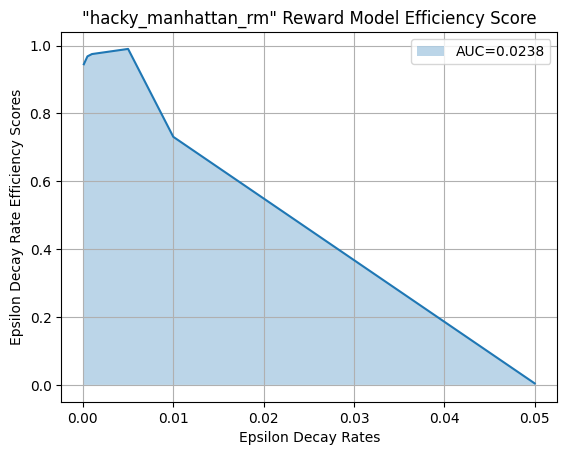

In [ ]:
def hacky_manhattan_rm(state):
    """Hacky reward model giving a reward of 10 for reaching the goal, -10 for falling in a hole, and a negative reward based on the Manhattan distance to the goal otherwise to encourage minimal path length."""
    state_x = state//ENV_DIM
    state_y = state%ENV_DIM
    state = str(env.unwrapped.desc[state_x][state_y])[2]
    if state == "G":
            return 10
    if state == "H":
        return -10
    else:
        manhattan_distance = (2 * ENV_DIM - state_x - state_y)
        return -1 - manhattan_distance / (2 * ENV_DIM)

generate_reward_model_efficiency_score(hacky_manhattan_rm)